## 드라이브 연결

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
import os
import sys

Mounted at /content/drive


## 필요 라이브러리 설치 및 적용

In [3]:
# 필요한 라이브러리와 해당 버전을 적어둔 txt 파일을 읽어오고 해당 라이브러리들을 설치
!pip install -r "/content/drive/MyDrive/model/PyTorch/requirements.txt"
# 이미지 전환을 해주는 라이브러리로 object detection task에서 이미지를 transform 적용하면 바운딩 박스도 함께 transform 되도록 해줌
!pip install albumentations==0.4.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# 필요한 라이브러리 불러오기
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2
import os
import sys

from sklearn import preprocessing 
from tqdm import tqdm

import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torchvision

from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch import nn
from torch import optim

import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from torch.utils.data import SequentialSampler
from torch.utils.tensorboard import SummaryWriter

import random

## 데이터 로드 및 DataFrame 화

In [5]:
random.seed(28)

BASE_PATH = "/content/drive/MyDrive/data/data/"
IMG_PATH = os.path.join(BASE_PATH, "image")
LABEL_PATH = os.path.join(BASE_PATH, "label")
IMG_FILES = [os.path.join(IMG_PATH, f) for f in os.listdir(IMG_PATH)]
LABEL_FILES = [os.path.join(LABEL_PATH, f) for f in os.listdir(LABEL_PATH)]
random.shuffle(LABEL_FILES)

In [6]:
def label_files_to_df(LABEL_FILES, IMG_PATH):
  width_list = []
  height_list = []
  label_list = []
  xmin_list = []
  ymin_list = []
  xmax_list = []
  ymax_list = []
  xml_path_list = []
  image_path_list = []
  image_id_list = []
  
  for i, xml_path in enumerate(LABEL_FILES):
    width = 0
    heigth = 0
    img_id = xml_path.split('/')
    #img_path = os.path.join(IMG_PATH, img_id[-1])
    img_id = img_id[-1].split('.')
    img_id = img_id[0]+"."+img_id[1]+"."+img_id[2]
    
    img_path = os.path.join(IMG_PATH, img_id + '.jpg')
    print(xml_path)

    xml_file = ET.parse(xml_path)
    root = xml_file.getroot()

    for obj in root.findall('size'):
      width = int(obj.find('width').text)
      height = int(obj.find('height').text)

    for obj in root.findall('object'):
      name = obj.find('name').text
        
      bndbox = obj[5]

      xmin = bndbox.find('xmin').text
      xmax = bndbox.find('xmax').text
      ymin = bndbox.find('ymin').text
      ymax = bndbox.find('ymax').text

      label_list.append(name)
      width_list.append(width)
      height_list.append(height)
      image_id_list.append(img_id)
      xmin_list.append(int(xmin))
      ymin_list.append(int(ymin))
      xmax_list.append(int(xmax))
      ymax_list.append(int(ymax))
      xml_path_list.append(xml_path)
      image_path_list.append(img_path)

  a = {
      'width': width_list,
      'height': height_list,
      'names': label_list,
      'xmin': xmin_list,
      'ymin': ymin_list,
      'xmax': xmax_list,
      'ymax': ymax_list,
      'txt_path':xml_path_list,
      'img_path':image_path_list,
      'img_id': image_id_list
  }

  df = pd.DataFrame.from_dict(a)

  return df      

xml_df = label_files_to_df(LABEL_FILES, IMG_PATH)
xml_df.head()

/content/drive/MyDrive/data/data/label/a73_darker90_jpeg.rf.615742f3799d5fe7d0ae7a54d6459bc6.xml
/content/drive/MyDrive/data/data/label/a96_darker80_jpeg.rf.83a1156be55a683fb4c6889c486562d3.xml
/content/drive/MyDrive/data/data/label/rent_darker60_jpg.rf.193079c595bfc6ad79ee02d7edbffaa4.xml
/content/drive/MyDrive/data/data/label/a107_darker80_jpeg.rf.e88f29303b1c3f62991000d6e19b29cd.xml
/content/drive/MyDrive/data/data/label/b24_jpeg.rf.f3db09f13da4f6c86dd821cd7cb5fffc.xml
/content/drive/MyDrive/data/data/label/transportation_darker60_png.rf.8792177bd249308023348191e99ea82d.xml
/content/drive/MyDrive/data/data/label/c43_darker80_jpeg.rf.23a439b7491d0256fefe06602d2582f3.xml
/content/drive/MyDrive/data/data/label/c7_darker60_jpeg.rf.82276bded977204cdfa3bd43108b98af.xml
/content/drive/MyDrive/data/data/label/a91_jpeg.rf.3e192b8c5e703a59144ee3dd06bd5b5b.xml
/content/drive/MyDrive/data/data/label/b51_darker60_jpeg.rf.54cc985b909c1afad2e4c1a5460dce96.xml
/content/drive/MyDrive/data/data/label

,width,height,names,xmin,ymin,xmax,ymax,txt_path,img_path,img_id
0,1280,1280,14,668,195,703,245,/content/drive/MyDrive/data/data/label/a73_dar...,/content/drive/MyDrive/data/data/image/a73_dar...,a73_darker90_jpeg.rf.615742f3799d5fe7d0ae7a54d...
1,1280,1280,19,697,662,731,709,/content/drive/MyDrive/data/data/label/a96_dar...,/content/drive/MyDrive/data/data/image/a96_dar...,a96_darker80_jpeg.rf.83a1156be55a683fb4c6889c4...
2,1280,1280,17,506,653,553,734,/content/drive/MyDrive/data/data/label/rent_da...,/content/drive/MyDrive/data/data/image/rent_da...,rent_darker60_jpg.rf.193079c595bfc6ad79ee02d7e...
3,1280,1280,4,614,650,661,733,/content/drive/MyDrive/data/data/label/rent_da...,/content/drive/MyDrive/data/data/image/rent_da...,rent_darker60_jpg.rf.193079c595bfc6ad79ee02d7e...
4,1280,1280,13,709,657,754,739,/content/drive/MyDrive/data/data/label/rent_da...,/content/drive/MyDrive/data/data/image/rent_da...,rent_darker60_jpg.rf.193079c595bfc6ad79ee02d7e...


In [7]:
# LabelEncoder로 각 label(현 상황에는 names)에 해당하는 숫자 label을 생성한다
# 이후 해당 데이터를 넣어준다
enc = preprocessing.LabelEncoder()
xml_df['labels'] = enc.fit_transform(xml_df['names'])
xml_df['labels'] = np.stack(xml_df['labels'][i]+1 for i in range(len(xml_df['labels'])))

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [8]:
classes = xml_df[['names','labels']].value_counts()
classes.to_dict()

{('4', 21): 610,
 ('14', 7): 560,
 ('19', 12): 555,
 ('8', 25): 550,
 ('13', 6): 520,
 ('0', 1): 445,
 ('17', 10): 340,
 ('11', 4): 300,
 ('12', 5): 295,
 ('2', 13): 275,
 ('20', 14): 275,
 ('18', 11): 260,
 ('24', 18): 250,
 ('3', 20): 250,
 ('15', 8): 250,
 ('6', 23): 245,
 ('7', 24): 225,
 ('21', 15): 210,
 ('1', 2): 195,
 ('10', 3): 195,
 ('5', 22): 190,
 ('22', 16): 185,
 ('23', 17): 155,
 ('25', 19): 155,
 ('16', 9): 150,
 ('9', 26): 150}

In [9]:
# classes라는 이름으로 우리가 어떠한 문자와 어떤 숫자가 연결이 된 것인지 확인
# 추 후 이 러시아 문자를 맞는 영어로 바꿔주는 작업을 한다면 영어 detiction이 가능함
# 아마 해당 깃허브에 있는 안젤리나 리더도 그런 방법을 선택한듯 함
temp = {}
for pair in classes.keys():
  temp[pair[1]] = pair[0]

print(f"classes: {temp}")
classes = temp
print(f"classes cnt: {len(classes)}")

classes: {21: '4', 7: '14', 12: '19', 25: '8', 6: '13', 1: '0', 10: '17', 4: '11', 5: '12', 13: '2', 14: '20', 11: '18', 18: '24', 20: '3', 8: '15', 23: '6', 24: '7', 15: '21', 2: '1', 3: '10', 22: '5', 16: '22', 17: '23', 19: '25', 9: '16', 26: '9'}
classes cnt: 26


In [10]:
xml_df.drop(columns=['names'], inplace=True)

In [11]:
xml_df

,width,height,xmin,ymin,xmax,ymax,txt_path,img_path,img_id,labels
0,1280,1280,668,195,703,245,/content/drive/MyDrive/data/data/label/a73_dar...,/content/drive/MyDrive/data/data/image/a73_dar...,a73_darker90_jpeg.rf.615742f3799d5fe7d0ae7a54d...,7
1,1280,1280,697,662,731,709,/content/drive/MyDrive/data/data/label/a96_dar...,/content/drive/MyDrive/data/data/image/a96_dar...,a96_darker80_jpeg.rf.83a1156be55a683fb4c6889c4...,12
2,1280,1280,506,653,553,734,/content/drive/MyDrive/data/data/label/rent_da...,/content/drive/MyDrive/data/data/image/rent_da...,rent_darker60_jpg.rf.193079c595bfc6ad79ee02d7e...,10
3,1280,1280,614,650,661,733,/content/drive/MyDrive/data/data/label/rent_da...,/content/drive/MyDrive/data/data/image/rent_da...,rent_darker60_jpg.rf.193079c595bfc6ad79ee02d7e...,21
4,1280,1280,709,657,754,739,/content/drive/MyDrive/data/data/label/rent_da...,/content/drive/MyDrive/data/data/image/rent_da...,rent_darker60_jpg.rf.193079c595bfc6ad79ee02d7e...,6
...,...,...,...,...,...,...,...,...,...,...
7785,1280,1280,220,625,252,672,/content/drive/MyDrive/data/data/label/b29_dar...,/content/drive/MyDrive/data/data/image/b29_dar...,b29_darker90_jpeg.rf.b6688c8515886a22241efd1d6...,23
7786,1280,1280,233,615,267,665,/content/drive/MyDrive/data/data/label/a64_dar...,/content/drive/MyDrive/data/data/image/a64_dar...,a64_darker70_jpeg.rf.068681f72e7ccb9414c9c3d1b...,5
7787,1280,1280,218,642,249,686,/content/drive/MyDrive/data/data/label/a24_dar...,/content/drive/MyDrive/data/data/image/a24_dar...,a24_darker60_jpeg.rf.42d7694582b3ecd418c3f8dcc...,21
7788,1280,1280,153,543,208,634,/content/drive/MyDrive/data/data/label/d79_dar...,/content/drive/MyDrive/data/data/image/d79_dar...,d79_darker60_jpeg.rf.8ad693a2286490590d80ff16b...,12


In [12]:
xml_df = xml_df.sample(frac=1).reset_index(drop=True)

In [13]:
train_filter = (xml_df.index < 2500)
val_filter1 = (xml_df.index >= 2500)
val_filter2 = (xml_df.index < 2900)
test_filter = (2900 <= xml_df.index)
df_train = xml_df[train_filter]
df_val = xml_df[val_filter1 & val_filter2]
df_test = xml_df[test_filter]

In [14]:
df_val.reset_index(inplace=True, drop=True)

In [15]:
df_train.reset_index(inplace=True, drop=True)

In [16]:
df_test.reset_index(inplace=True, drop=True)

In [17]:
df_train

,width,height,xmin,ymin,xmax,ymax,txt_path,img_path,img_id,labels
0,1280,1280,636,180,698,247,/content/drive/MyDrive/data/data/label/d11_dar...,/content/drive/MyDrive/data/data/image/d11_dar...,d11_darker60_jpeg.rf.debd9c0b29e37b2cebedc2f55...,13
1,1280,1280,709,668,741,711,/content/drive/MyDrive/data/data/label/b11_dar...,/content/drive/MyDrive/data/data/image/b11_dar...,b11_darker60_jpeg.rf.ee3109f8bcbf0912b1c27c2d4...,20
2,1280,1280,1099,641,1127,683,/content/drive/MyDrive/data/data/label/b2_dark...,/content/drive/MyDrive/data/data/image/b2_dark...,b2_darker90_jpeg.rf.33c9a089f057bded5ffccf7bcd...,2
3,1280,1280,825,739,873,815,/content/drive/MyDrive/data/data/label/univers...,/content/drive/MyDrive/data/data/image/univers...,university_darker80_jpg.rf.0546731e544512fe69a...,25
4,1280,1280,250,567,285,620,/content/drive/MyDrive/data/data/label/c59_dar...,/content/drive/MyDrive/data/data/image/c59_dar...,c59_darker80_jpeg.rf.3698be6d78e77f5b976651128...,6
...,...,...,...,...,...,...,...,...,...,...
2495,1280,1280,796,662,833,722,/content/drive/MyDrive/data/data/label/see_you...,/content/drive/MyDrive/data/data/image/see_you...,see_you_tomorrow_darker60_jpg.rf.71c1269174546...,5
2496,1280,1280,520,674,555,737,/content/drive/MyDrive/data/data/label/you_hav...,/content/drive/MyDrive/data/data/image/you_hav...,you_have_a_cough_jpg.rf.41acb5e7f18f79985b6b3f...,15
2497,1280,1280,774,666,815,744,/content/drive/MyDrive/data/data/label/technol...,/content/drive/MyDrive/data/data/image/technol...,technology_darker90_jpg.rf.64c78455c2060547a97...,4
2498,1280,1280,651,1092,682,1139,/content/drive/MyDrive/data/data/label/b35_dar...,/content/drive/MyDrive/data/data/image/b35_dar...,b35_darker90_jpeg.rf.089e208fc8db672830f302c9c...,24


In [18]:
df_val.astype({'img_id':'str'})
df_train.astype({'img_id':'str'})
df_test.astype({'img_id':'str'})

,width,height,xmin,ymin,xmax,ymax,txt_path,img_path,img_id,labels
0,1280,1280,1114,660,1148,721,/content/drive/MyDrive/data/data/label/see_you...,/content/drive/MyDrive/data/data/image/see_you...,see_you_tomorrow_darker80_jpg.rf.ce48b92a6eb35...,7
1,1280,1280,683,656,725,726,/content/drive/MyDrive/data/data/label/foundat...,/content/drive/MyDrive/data/data/image/foundat...,foundation_darker70_jpg.rf.f4ab1397ceb5e3b911e...,1
2,1280,1280,1001,564,1067,647,/content/drive/MyDrive/data/data/label/d116_da...,/content/drive/MyDrive/data/data/image/d116_da...,d116_darker60_jpeg.rf.c0ca06efba9de9bc36433639...,5
3,1280,1280,889,496,924,564,/content/drive/MyDrive/data/data/label/get_in_...,/content/drive/MyDrive/data/data/image/get_in_...,get_in_the_line_darker80_jpg.rf.0e5e61026d7c94...,4
4,1280,1280,762,629,796,690,/content/drive/MyDrive/data/data/label/take_a_...,/content/drive/MyDrive/data/data/image/take_a_...,take_a_bite_darker80_jpg.rf.ee314a4a175ed51511...,12
...,...,...,...,...,...,...,...,...,...,...
4885,1280,1280,663,219,693,262,/content/drive/MyDrive/data/data/label/a48_jpe...,/content/drive/MyDrive/data/data/image/a48_jpe...,a48_jpeg.rf.fe682ecbb0237babd81a69e27cdb36f1,26
4886,1280,1280,570,696,607,761,/content/drive/MyDrive/data/data/label/i_think...,/content/drive/MyDrive/data/data/image/i_think...,i_think_so_darker70_jpg.rf.461380e6a575e1664a3...,25
4887,1280,1280,180,561,218,624,/content/drive/MyDrive/data/data/label/stop_ta...,/content/drive/MyDrive/data/data/image/stop_ta...,stop_talking_darker70_jpg.rf.1b21eb258c8c51741...,11
4888,1280,1280,740,662,781,715,/content/drive/MyDrive/data/data/label/b61_dar...,/content/drive/MyDrive/data/data/image/b61_dar...,b61_darker70_jpeg.rf.c9564595858d7a8e73024fd6a...,6


## Dataset & DataLoader

In [19]:
# Dataset을 만들어준다
# 필요한 함수인 init, getitem, len을 설정해준다
# 이렇게 설정해줘야 dataloader를 통한 배치별 파일 로드가 동작한다
class VOCDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        # 상속처리
        super().__init__()
        # image_ids(파일의 이름) array 
        self.image_ids = dataframe['img_id'].unique()
        # df(원본 dataframe)
        self.df = dataframe
        # 파일의 이름이 있는 경로(기본경로)
        self.image_dir = image_dir
        # transforms
        self.transforms = transforms
    
    # 아이탬을 뽑아올 수 있게 해주는 함수
    def __getitem__(self, index: int):
        # 우선 인덱스가 들어오면 해당 인덱스의 파일 이름을 찾는다
        image_id = self.image_ids[index]
        # 해당 파일 df row를 찾는다(다른 정보도 알아오기 위해서)
        records = self.df[self.df['img_id'] == image_id]
        # 이미지 파일을 불러들인 후 RGB형식으로 바꾸고 각 값을 255로 나눈다
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        # 가로 세로 규격 파악
        rows, cols = image.shape[:2]
        
        # 박스 정보를 가져온다
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
        # 면적 계산
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        # 라벨 확인
        label = records['labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        # 타겟 정보를 dict화 해서 저장
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        # transforms가 있다면 적용
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)
            
            return image, target
    # len 함수 생성
    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [20]:
# transform 생성
def get_transform_train():
    return A.Compose([
        A.RandomBrightnessContrast(p=0.2),
        A.RandomSizedBBoxSafeCrop(width=256, height=256, p=0.2),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

def get_transform_test():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [21]:
# 배치 사이즈가 안맞을 경우? 를 대비한 함수
def collate_fn(batch):
    return tuple(zip(*batch))

# 데이타 셋 생성
train_dataset = VOCDataset(df_train, IMG_PATH , get_transform_train())
val_dataset = VOCDataset(df_val, IMG_PATH, get_transform_valid())
test_dataset = VOCDataset(df_test, IMG_PATH, get_transform_test())

# 데이타 로더 생성

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


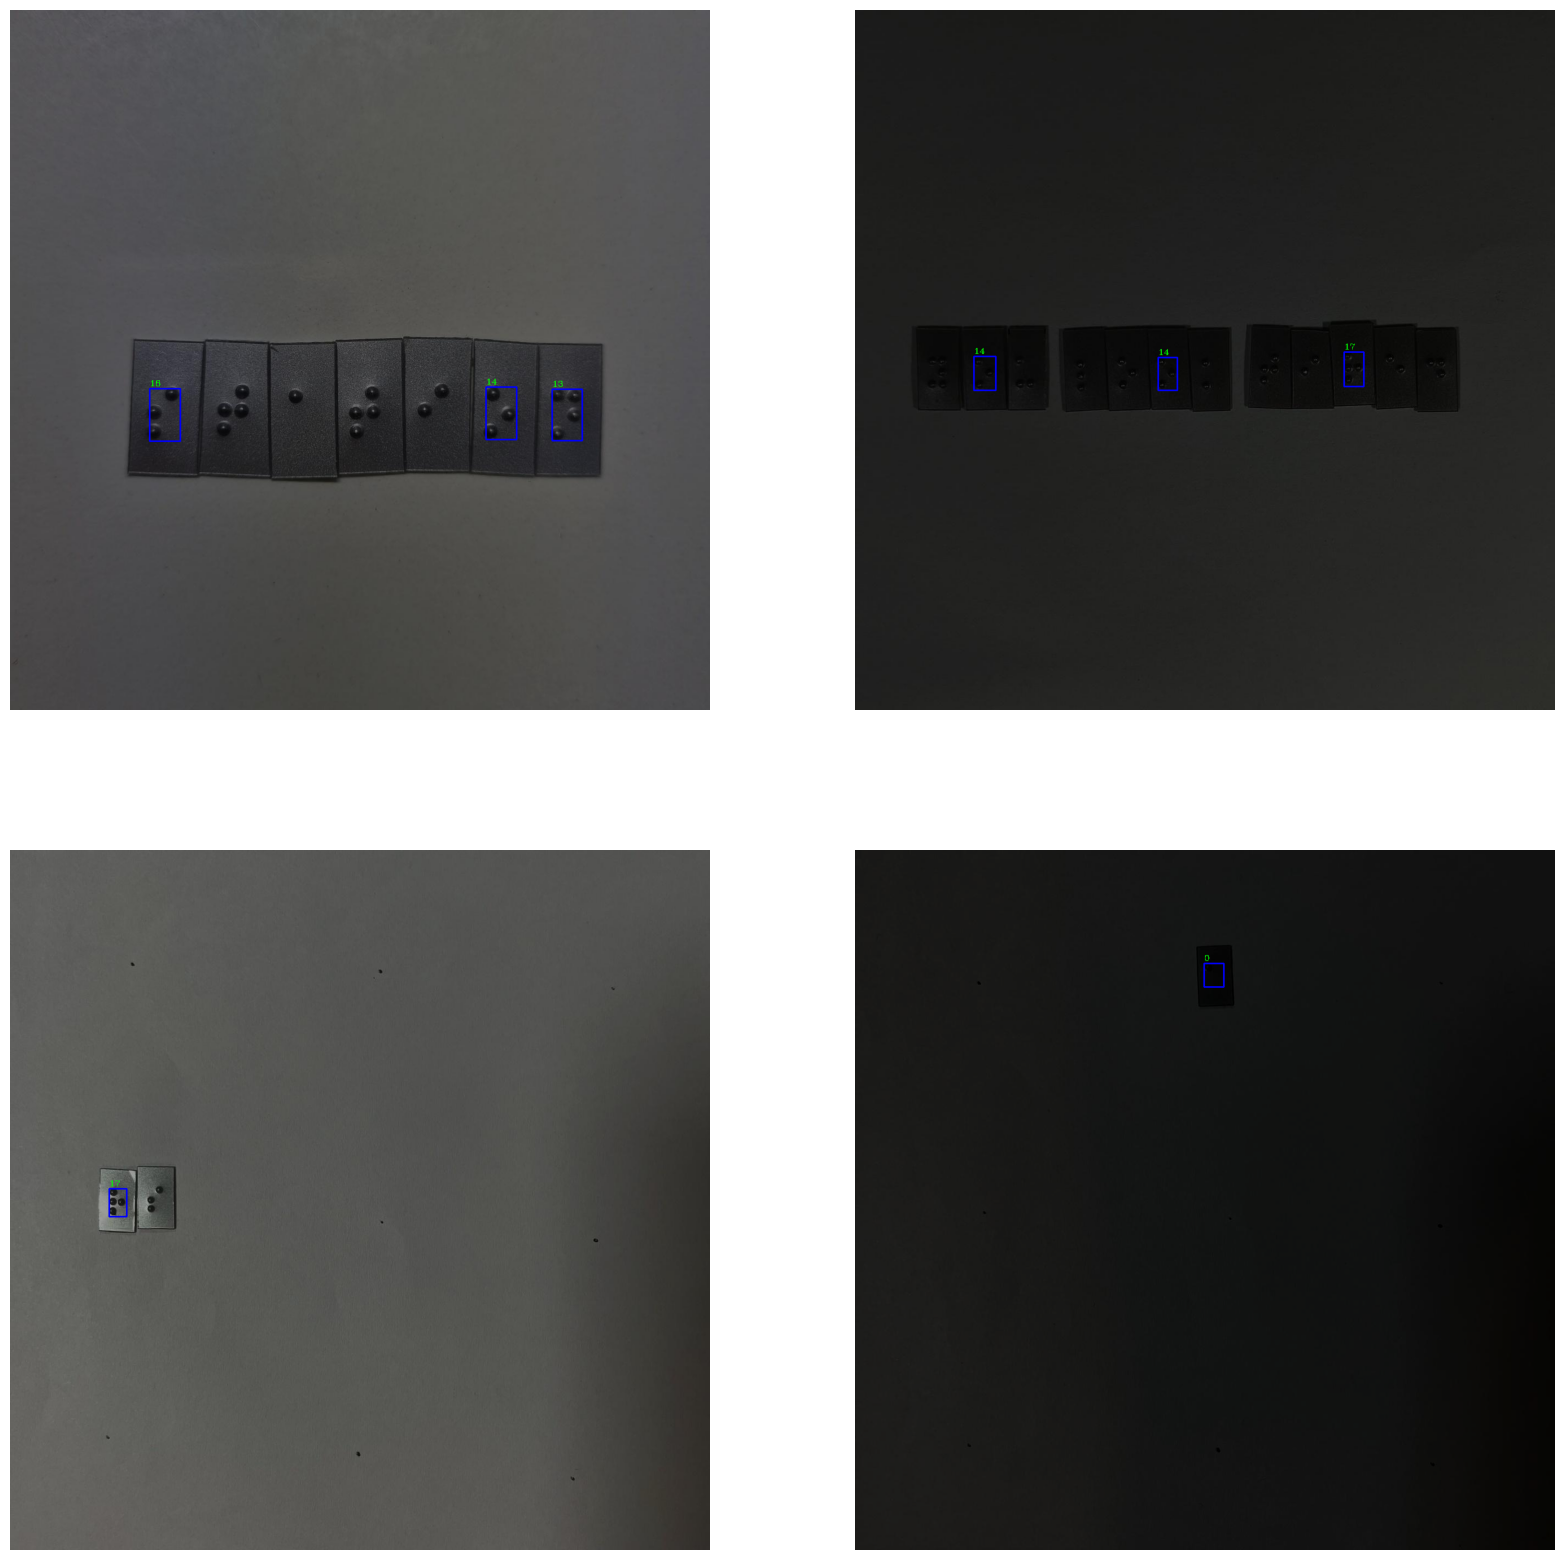

In [23]:
# 배치만큼 정보 받아오기
images, targets= next(iter(train_data_loader))
# device로 이동
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

plt.figure(figsize=(20,20))
# images, targets 쌍으로 만들어 돌면서 box와 label 작업 진행
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    # box의 경우 한 이미지에 여러개이니 for문을 통해서 사각형을 각각 만든다
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        # 라벨 처리
        cv2.putText(sample, classes[names[i]], (box[0],box[1] - 5),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)

## Model 불러오기

In [25]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
WEIGHTS_FILE = "/content/drive/MyDrive/param/happy_faster_rcnn_model_ver3.pth"
num_classes = 36
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# Load the traines weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]

##이 밑에 있는 코드 3줄은 특수경우용

In [ ]:
# pretrained 모델을 불러온다
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
"""
for param in model.parameters(): # False로 설정함으로써 마지막 classifier를 제외한 모든 부분을 고정하여 backward()중에 경사도 계산이 되지 않도록 합니다.
    param.requires_grad = False
"""

In [ ]:
# 분류할 종류만큼 class를 바꿔준다
num_classes = 27
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# model을 device에 올리고 파라미터와 옵티마이저, 스캐줄러 설정
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.RAdam(model.parameters(), lr= 0.0001) #, weight_decay= 0.0005
#optimizer = torch.optim.SGD(params, lr= 0.005, weight_decay= 0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma= 0.1)

## Train

In [26]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ayuvf92n
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ayuvf92n
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=386225 sha256=28fa71004bddeb73e1cb4ba0f58ad4b356ab7599c417ef5e449889220c88b6e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-9ag3qzr_/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.6:
      Successfully uninstalled pycocotools-2.0.6


In [27]:
!git clone https://github.com/pytorch/vision.git
!cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 335228, done.
remote: Counting objects: 100% (51302/51302), done.
remote: Compressing objects: 100% (803/803), done.
remote: Total 335228 (delta 50677), reused 50974 (delta 50475), pack-reused 283926
Receiving objects: 100% (335228/335228), 674.00 MiB | 16.91 MiB/s, done.
Resolving deltas: 100% (308734/308734), done.


In [28]:
from engine import train_one_epoch, evaluate
import utils

In [29]:
num_epochs = 10
# optimizer = torch.optim.NAdam(params, lr= 0.0002, weight_decay= 0.0005)
optimizer = torch.optim.SGD(params, lr= 0.0025, weight_decay= 0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma= 0.8) 

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, val_data_loader, device=device)

Epoch: [0]  [  0/379]  eta: 1:18:58  lr: 0.000009  loss: 1.0927 (1.0927)  loss_classifier: 0.4015 (0.4015)  loss_box_reg: 0.0116 (0.0116)  loss_objectness: 0.6677 (0.6677)  loss_rpn_box_reg: 0.0119 (0.0119)  time: 12.5023  data: 2.8818  max mem: 6329
Epoch: [0]  [100/379]  eta: 0:07:23  lr: 0.000670  loss: 0.3112 (0.5739)  loss_classifier: 0.1296 (0.2183)  loss_box_reg: 0.0315 (0.0272)  loss_objectness: 0.1182 (0.3172)  loss_rpn_box_reg: 0.0098 (0.0112)  time: 1.4909  data: 0.6212  max mem: 6353
Epoch: [0]  [200/379]  eta: 0:04:36  lr: 0.001331  loss: 0.4027 (0.4942)  loss_classifier: 0.2212 (0.2232)  loss_box_reg: 0.1195 (0.0678)  loss_objectness: 0.0370 (0.1925)  loss_rpn_box_reg: 0.0087 (0.0107)  time: 1.5089  data: 0.6324  max mem: 6353
Epoch: [0]  [300/379]  eta: 0:02:00  lr: 0.001991  loss: 0.3465 (0.4702)  loss_classifier: 0.1982 (0.2279)  loss_box_reg: 0.1335 (0.0918)  loss_objectness: 0.0188 (0.1407)  loss_rpn_box_reg: 0.0055 (0.0098)  time: 1.4844  data: 0.6026  max mem: 6353

In [30]:
torch.save(model.state_dict(), 'new_pre_model_45epoch.pth')